In [1]:
# ============================================================
# 0. SETUP
# ============================================================

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')


In [2]:
# ============================================================
# 1. LOAD FEATURES
# ============================================================

# We assume X_features.csv exists from previous notebook
X_full = pd.read_csv("X_features.csv")
print("Shape of full feature set:", X_full.shape)
X_full.head()


Shape of full feature set: (46956, 10)


,Engine size,Mileage,Age,Price_per_km,Manufacturer_Ford,Manufacturer_Porsche,Manufacturer_Toyota,Manufacturer_VW,Fuel type_Hybrid,Fuel type_Petrol
0,1.0000,127300,23,0.0241,True,False,False,False,False,True
1,1.6000,39190,11,0.6142,True,False,False,False,False,False
2,1.8000,210814,37,0.0081,False,False,True,False,True,False
3,1.0000,127869,19,0.0321,False,False,False,True,False,True
4,1.4000,33603,7,0.8691,True,False,False,False,False,True


In [3]:
# ============================================================
# 2. SELECT FEATURES FOR CLUSTERING
# ============================================================
# H2: K-Means vs DBSCAN for segmenting vehicles.
# Use meaningful numeric features for clustering.

# Try to use intuitive features. Adjust names if they differ.
candidate_cols = [col for col in X_full.columns
                  if any(x in col for x in ["Mileage", "Engine size", "Age", "Price_per_km"])]

print("Candidate numeric clustering features:")
print(candidate_cols)

X_cluster = X_full[candidate_cols].copy()
print("\nX_cluster shape:", X_cluster.shape)
X_cluster.head()


Candidate numeric clustering features:
['Engine size', 'Mileage', 'Age', 'Price_per_km']

X_cluster shape: (46956, 4)


,Engine size,Mileage,Age,Price_per_km
0,1.0000,127300,23,0.0241
1,1.6000,39190,11,0.6142
2,1.8000,210814,37,0.0081
3,1.0000,127869,19,0.0321
4,1.4000,33603,7,0.8691


In [4]:
# ============================================================
# 3. SCALE FEATURES
# ============================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print("Scaled feature matrix shape:", X_scaled.shape)


Scaled feature matrix shape: (46956, 4)


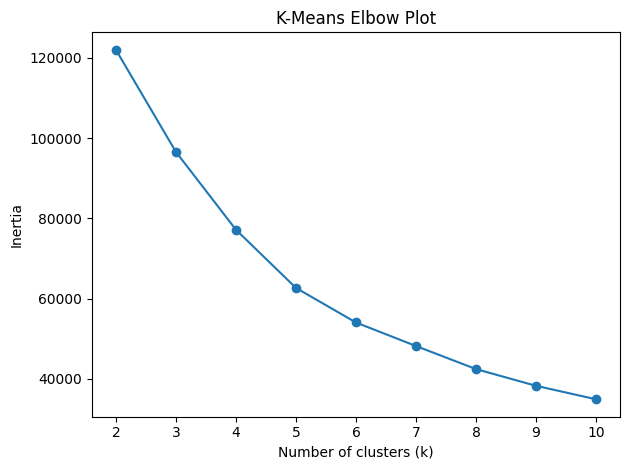

In [5]:
# ============================================================
# 4. K-MEANS: ELBOW METHOD TO CHOOSE k
# ============================================================

inertias = []
k_values = range(2, 11)  # 2 to 10 clusters

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(k_values, inertias, marker="o")
plt.title("K-Means Elbow Plot")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.tight_layout()
plt.show()


In [7]:
# ============================================================
# 5. CHOOSE k (MANUALLY) AND FIT FINAL K-MEANS
# ============================================================
# After looking at the elbow plot, set k_best accordingly.
# For now, choose a reasonable value, e.g., k=4.
# You can change it after visually inspecting the plot.

k_best = 4  # <-- adjust after checking the elbow

kmeans = KMeans(n_clusters=k_best, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

print("K-Means cluster counts:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
print(dict(zip(unique, counts)))

# Silhouette score for K-Means
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
print(f"K-Means silhouette score (k={k_best}): {kmeans_sil:.4f}")


K-Means cluster counts:
{np.int32(0): np.int64(20846), np.int32(1): np.int64(2754), np.int32(2): np.int64(1002), np.int32(3): np.int64(22354)}
K-Means silhouette score (k=4): 0.4086


In [8]:
# ============================================================
# 6. DBSCAN CLUSTERING
# ============================================================
# eps and min_samples need tuning; start with some defaults and adjust if needed.
# If too many points are labeled as -1 (noise), tweak eps/min_samples.

dbscan = DBSCAN(eps=0.7, min_samples=20)  # you can adjust these
dbscan_labels = dbscan.fit_predict(X_scaled)

print("DBSCAN cluster label counts:")
unique_db, counts_db = np.unique(dbscan_labels, return_counts=True)
print(dict(zip(unique_db, counts_db)))


DBSCAN cluster label counts:
{np.int64(-1): np.int64(102), np.int64(0): np.int64(45144), np.int64(1): np.int64(268), np.int64(2): np.int64(1122), np.int64(3): np.int64(320)}


In [9]:
# ============================================================
# 7. SILHOUETTE SCORE FOR DBSCAN (EXCLUDING NOISE)
# ============================================================

# Silhouette score requires at least 2 clusters and no single cluster dominating.
# DBSCAN label -1 is noise.

mask = dbscan_labels != -1
if len(np.unique(dbscan_labels[mask])) > 1 and mask.sum() > 0:
    dbscan_sil = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    print(f"DBSCAN silhouette score (excluding noise): {dbscan_sil:.4f}")
else:
    dbscan_sil = None
    print("DBSCAN silhouette score not computed (too few clusters or all noise).")


DBSCAN silhouette score (excluding noise): 0.3554


In [10]:
# ============================================================
# 8. H2 COMPARISON: K-MEANS vs DBSCAN
# ============================================================

print("=== H2: Clustering Performance Comparison ===")
print(f"K-Means silhouette score: {kmeans_sil:.4f}")
print(f"DBSCAN silhouette score: {dbscan_sil if dbscan_sil is not None else 'N/A'}")

if dbscan_sil is None or kmeans_sil > (dbscan_sil or -1):
    print("\nPreliminary conclusion: K-Means outperforms DBSCAN on this dataset.")
else:
    print("\nPreliminary conclusion: DBSCAN performs comparably or better than K-Means.")


=== H2: Clustering Performance Comparison ===
K-Means silhouette score: 0.4086
DBSCAN silhouette score: 0.35539080784743254

Preliminary conclusion: K-Means outperforms DBSCAN on this dataset.


Explained variance ratios (PCA): [0.53873876 0.24649467]


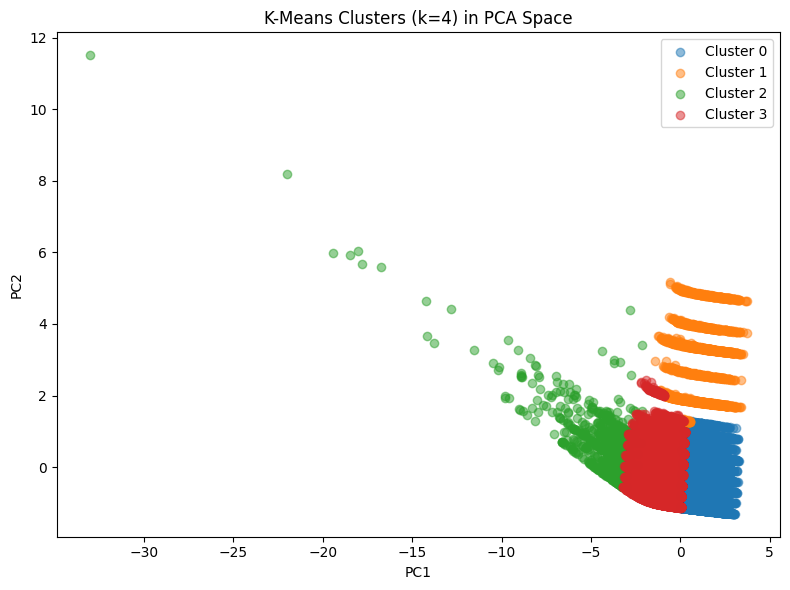

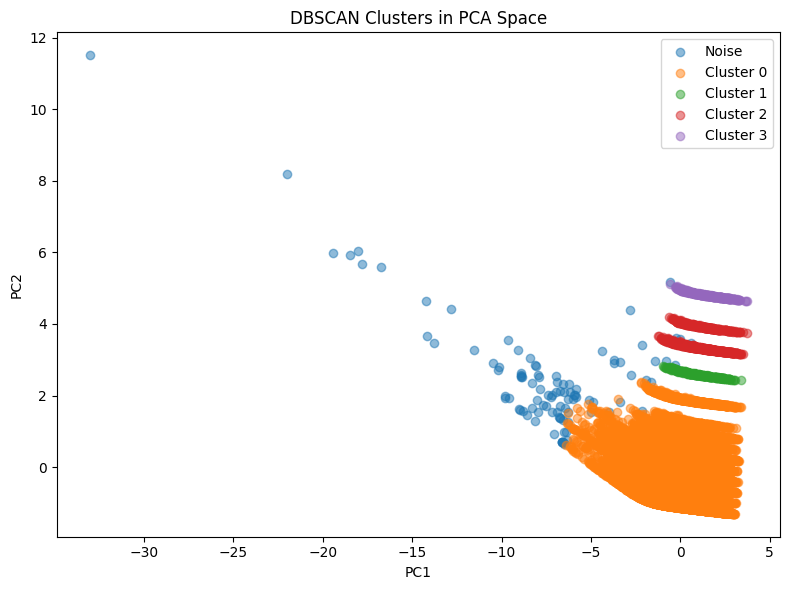

In [11]:
# ============================================================
# 9. PCA FOR VISUALIZATION OF CLUSTERS
# ============================================================

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratios (PCA):", pca.explained_variance_ratio_)

# Plot K-Means clusters
plt.figure(figsize=(8, 6))
for c in np.unique(kmeans_labels):
    plt.scatter(X_pca[kmeans_labels == c, 0],
                X_pca[kmeans_labels == c, 1],
                label=f"Cluster {c}",
                alpha=0.5)
plt.title(f"K-Means Clusters (k={k_best}) in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# Plot DBSCAN clusters (including noise)
plt.figure(figsize=(8, 6))
for c in np.unique(dbscan_labels):
    label = "Noise" if c == -1 else f"Cluster {c}"
    plt.scatter(X_pca[dbscan_labels == c, 0],
                X_pca[dbscan_labels == c, 1],
                label=label,
                alpha=0.5)
plt.title("DBSCAN Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# ============================================================
# 10. ATTACH CLUSTER LABELS BACK TO ORIGINAL DATA
# ============================================================
# We'll load the original feature-engineered dataframe to attach labels.

df_model = pd.read_csv("car_sales_feature_engineered.csv")
print("df_model shape:", df_model.shape)

# Ensure same row order as X_full (they should match if we haven't shuffled)
df_model["KMeans_Cluster"] = kmeans_labels
df_model["DBSCAN_Cluster"] = dbscan_labels

df_model.head()


df_model shape: (46956, 11)


,Engine size,Mileage,Price,Age,Price_per_km,Manufacturer_Ford,Manufacturer_Porsche,Manufacturer_Toyota,Manufacturer_VW,Fuel type_Hybrid,Fuel type_Petrol,KMeans_Cluster,DBSCAN_Cluster
0,1.0000,127300,3074,23,0.0241,True,False,False,False,False,True,0,0
1,1.6000,39190,24072,11,0.6142,True,False,False,False,False,False,3,0
2,1.8000,210814,1705,37,0.0081,False,False,True,False,True,False,0,0
3,1.0000,127869,4101,19,0.0321,False,False,False,True,False,True,3,0
4,1.4000,33603,29204,7,0.8691,True,False,False,False,False,True,3,0


In [13]:
# ============================================================
# 11. CLUSTER PROFILES (K-MEANS)
# ============================================================

cluster_profile = df_model.groupby("KMeans_Cluster")[["Price", "Mileage", "Engine size", "Age"]].mean()
print("K-Means cluster profile (mean values):")
cluster_profile


K-Means cluster profile (mean values):


,Price,Mileage,Engine size,Age
KMeans_Cluster,,,,
0,"3,163.8410","169,927.6518",1.5997,29.2841
1,"14,513.0712","141,331.9826",3.7366,25.4651
2,"34,076.6148","11,532.4192",1.4883,5.9461
3,"17,089.5034","65,859.3904",1.5793,14.2819


In [14]:
# ============================================================
# 12. SIMPLE RECOMMENDATION FUNCTION (BASED ON K-MEANS)
# ============================================================
# Approach:
#  - Given a car index, find its cluster
#  - Recommend N other cars from same cluster, closest in mileage & price

from sklearn.metrics.pairwise import euclidean_distances

def recommend_similar_cars(df, index, n_recommendations=5):
    """
    Recommend similar cars based on K-Means cluster and distance in selected features.
    df: dataframe with at least Price, Mileage, Engine size, Age, KMeans_Cluster
    index: index (row) of the query car
    """
    if index not in df.index:
        raise ValueError("Index not found in dataframe.")

    query_row = df.loc[index]
    cluster = query_row["KMeans_Cluster"]

    # Filter cars in same cluster, excluding the query car
    cluster_df = df[df["KMeans_Cluster"] == cluster].copy()
    cluster_df = cluster_df.drop(index=index)

    if len(cluster_df) == 0:
        print("No other cars in the same cluster.")
        return cluster_df

    # Features used for similarity within cluster
    feat_cols = ["Price", "Mileage", "Engine size", "Age"]

    query_vec = query_row[feat_cols].values.reshape(1, -1)
    cluster_mat = cluster_df[feat_cols].values

    dists = euclidean_distances(query_vec, cluster_mat)[0]

    cluster_df = cluster_df.copy()
    cluster_df["distance"] = dists

    # Return top-N nearest neighbors
    return cluster_df.nsmallest(n_recommendations, "distance")

# Example usage:
example_index = df_model.index[0]
print(f"Query car at index {example_index}:")
print(df_model.loc[example_index][["Price", "Mileage", "Engine size", "Age", "KMeans_Cluster"]])

print("\nTop 5 recommendations:")
recommend_similar_cars(df_model, example_index, n_recommendations=5)[["Price", "Mileage", "Engine size", "Age", "KMeans_Cluster", "distance"]]


Query car at index 0:
Price               3074
Mileage           127300
Engine size       1.0000
Age                   23
KMeans_Cluster         0
Name: 0, dtype: object

Top 5 recommendations:


,Price,Mileage,Engine size,Age,KMeans_Cluster,distance
42053,3025,127276,1.2000,25,0,54.5989
36893,3059,127174,1.4000,26,0,126.9258
39140,3192,127373,1.0000,28,0,138.8452
46712,3123,127431,2.0000,35,0,140.3816
45990,2927,127251,1.4000,29,0,155.0682


In [15]:
# ============================================================
# 13. SAVE CLUSTERED DATA FOR THESIS & BUSINESS ANALYSIS
# ============================================================

df_model.to_csv("car_sales_with_clusters.csv", index=False)

print("Saved car_sales_with_clusters.csv with KMeans_Cluster and DBSCAN_Cluster.")
print("Use this for business insight tables (segment profiles, price bands, etc).")


Saved car_sales_with_clusters.csv with KMeans_Cluster and DBSCAN_Cluster.
Use this for business insight tables (segment profiles, price bands, etc).
